E91 quantum key distribution protocol

https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/e91_qkd/e91_quantum_key_distribution_protocol.ipynb

 In this section we simulate the E91 quantum key distribution protocol without the presence of an eavesdropper.

In [1]:
import qiskit
# useful additional packages 
import numpy as np
import random
# regular expressions module
import re

# importing the QISKit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer

# import basic plot tools
from qiskit.tools.visualization import circuit_drawer, plot_histogram

In [2]:
# Creating registers
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(4, name="cr")

singlet = QuantumCircuit(qr, cr, name='singlet')
singlet.x(qr[0])
singlet.x(qr[1])
singlet.h(qr[0])
singlet.cx(qr[0],qr[1])

In [3]:
## Alice's measurement circuits

# measure the spin projection of Alice's qubit onto the a_1 direction (X basis)
measureA1 = QuantumCircuit(qr, cr, name='measureA1')
measureA1.h(qr[0])
measureA1.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_2 direction (W basis)
measureA2 = QuantumCircuit(qr, cr, name='measureA2')
measureA2.s(qr[0])
measureA2.h(qr[0])
measureA2.t(qr[0])
measureA2.h(qr[0])
measureA2.measure(qr[0],cr[0])

# measure the spin projection of Alice's qubit onto the a_3 direction (standard Z basis)
measureA3 = QuantumCircuit(qr, cr, name='measureA3')
measureA3.measure(qr[0],cr[0])

## Bob's measurement circuits

# measure the spin projection of Bob's qubit onto the b_1 direction (W basis)
measureB1 = QuantumCircuit(qr, cr, name='measureB1')
measureB1.s(qr[1])
measureB1.h(qr[1])
measureB1.t(qr[1])
measureB1.h(qr[1])
measureB1.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
measureB2 = QuantumCircuit(qr, cr, name='measureB2')
measureB2.measure(qr[1],cr[1])

# measure the spin projection of Bob's qubit onto the b_3 direction (V basis)
measureB3 = QuantumCircuit(qr, cr, name='measureB3')
measureB3.s(qr[1])
measureB3.h(qr[1])
measureB3.tdg(qr[1])
measureB3.h(qr[1])
measureB3.measure(qr[1],cr[1])

## Lists of measurement circuits
aliceMeasurements = [measureA1, measureA2, measureA3]
bobMeasurements = [measureB1, measureB2, measureB3]

In [4]:
# Define the number of singlets N
numberOfSinglets = 500

In [5]:
aliceMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] # string b of Alice
bobMeasurementChoices = [random.randint(1, 3) for i in range(numberOfSinglets)] # string b' of Bob

In [6]:
circuits = [] # the list in which the created circuits will be stored

for i in range(numberOfSinglets):
    # create the name of the i-th circuit depending on Alice's and Bob's measurement choices
    circuitName = str(i) + ':A' + str(aliceMeasurementChoices[i]) + '_B' + str(bobMeasurementChoices[i])
    
    # create the joint measurement circuit
    # add Alice's and Bob's measurement circuits to the singlet state curcuit
    # singlet state circuit # measurement circuit of Alice # measurement circuit of Bob
    circuitName = singlet + aliceMeasurements[aliceMeasurementChoices[i]-1] + bobMeasurements[bobMeasurementChoices[i]-1] 
    
    # add the created circuit to the circuits list
    circuits.append(circuitName)

C:\Users\diego\AppData\Local\Temp/ipykernel_28360/2841344896.py:10: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuitName = singlet + aliceMeasurements[aliceMeasurementChoices[i]-1] + bobMeasurements[bobMeasurementChoices[i]-1]


In [7]:
print(circuits[0].name)

circuit-93


Step three: recording the results

In [8]:
backend=BasicAer.get_backend('qasm_simulator')
result = execute(circuits, backend=backend, shots=1).result()  
#print(result) # uncomment for detailed result

In [9]:
result.get_counts(circuits[0])

{'0000': 1}

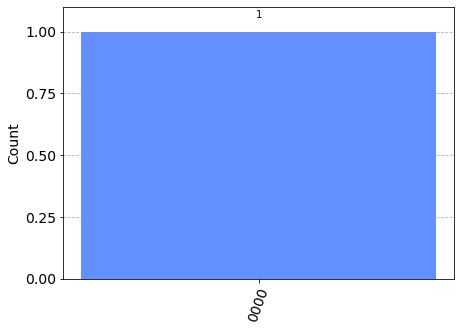

In [10]:
plot_histogram(result.get_counts(circuits[0]))

In [11]:
abPatterns = [
    re.compile('..00$'), # search for the '..00' output (Alice obtained -1 and Bob obtained -1)
    re.compile('..01$'), # search for the '..01' output
    re.compile('..10$'), # search for the '..10' output (Alice obtained -1 and Bob obtained 1)
    re.compile('..11$')  # search for the '..11' output
]

In [12]:
aliceResults = [] # Alice's results (string a)
bobResults = [] # Bob's results (string a')

for i in range(numberOfSinglets):

    res = list(result.get_counts(circuits[i]).keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit
    
    if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(-1) # Bob got the result -1
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(1) # Bob got the result 1
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

Step four: revealing the bases

In [13]:
aliceKey = [] # Alice's key string k
bobKey = [] # Bob's key string k'

# comparing the stings with measurement choices
for i in range(numberOfSinglets):
    # if Alice and Bob have measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
    if (aliceMeasurementChoices[i] == 2 and bobMeasurementChoices[i] == 1) or (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 2):
        aliceKey.append(aliceResults[i]) # record the i-th result obtained by Alice as the bit of the secret key k
        bobKey.append(- bobResults[i]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
        
keyLength = len(aliceKey) # length of the secret key

In [14]:
abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]:
        abKeyMismatches += 1

Step five: CHSH correlation value test

In [15]:
# function that calculates CHSH correlation value
def chsh_corr(result):
    
    # lists with the counts of measurement results
    # each element represents the number of (-1,-1), (-1,1), (1,-1) and (1,1) results respectively
    countA1B1 = [0, 0, 0, 0] # XW observable
    countA1B3 = [0, 0, 0, 0] # XV observable
    countA3B1 = [0, 0, 0, 0] # ZW observable
    countA3B3 = [0, 0, 0, 0] # ZV observable

    for i in range(numberOfSinglets):

        res = list(result.get_counts(circuits[i]).keys())[0]

        # if the spins of the qubits of the i-th singlet were projected onto the a_1/b_1 directions
        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B1[j] += 1

        if (aliceMeasurementChoices[i] == 1 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA1B3[j] += 1

        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 1):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B1[j] += 1
                    
        # if the spins of the qubits of the i-th singlet were projected onto the a_3/b_3 directions
        if (aliceMeasurementChoices[i] == 3 and bobMeasurementChoices[i] == 3):
            for j in range(4):
                if abPatterns[j].search(res):
                    countA3B3[j] += 1
                    
    # number of the results obtained from the measurements in a particular basis
    total11 = sum(countA1B1)
    total13 = sum(countA1B3)
    total31 = sum(countA3B1)
    total33 = sum(countA3B3)      
                    
    # expectation values of XW, XV, ZW and ZV observables (2)
    expect11 = (countA1B1[0] - countA1B1[1] - countA1B1[2] + countA1B1[3])/total11 # -1/sqrt(2)
    expect13 = (countA1B3[0] - countA1B3[1] - countA1B3[2] + countA1B3[3])/total13 # 1/sqrt(2)
    expect31 = (countA3B1[0] - countA3B1[1] - countA3B1[2] + countA3B1[3])/total31 # -1/sqrt(2)
    expect33 = (countA3B3[0] - countA3B3[1] - countA3B3[2] + countA3B3[3])/total33 # -1/sqrt(2) 
    
    corr = expect11 - expect13 + expect31 + expect33 # calculate the CHSC correlation value (3)
    
    return corr

Output
Now let us print all the interesting values.

In [16]:
corr = chsh_corr(result) # CHSH correlation value

# CHSH inequality test
print('CHSH correlation value: ' + str(round(corr, 3)))

# Keys
print('Length of the key: ' + str(keyLength))
print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

CHSH correlation value: -2.827
Length of the key: 122
Number of mismatching bits: 0



Simulation of eavesdropping

In [17]:
# measurement of the spin projection of Alice's qubit onto the a_2 direction (W basis)
measureEA2 = QuantumCircuit(qr, cr, name='measureEA2')
measureEA2.s(qr[0])
measureEA2.h(qr[0])
measureEA2.t(qr[0])
measureEA2.h(qr[0])
measureEA2.measure(qr[0],cr[2])

# measurement of the spin projection of Allice's qubit onto the a_3 direction (standard Z basis)
measureEA3 = QuantumCircuit(qr, cr, name='measureEA3')
measureEA3.measure(qr[0],cr[2])

# measurement of the spin projection of Bob's qubit onto the b_1 direction (W basis)
measureEB1 = QuantumCircuit(qr, cr, name='measureEB1')
measureEB1.s(qr[1])
measureEB1.h(qr[1])
measureEB1.t(qr[1])
measureEB1.h(qr[1])
measureEB1.measure(qr[1],cr[3])

# measurement of the spin projection of Bob's qubit onto the b_2 direction (standard Z measurement)
measureEB2 = QuantumCircuit(qr, cr, name='measureEB2')
measureEB2.measure(qr[1],cr[3])

# lists of measurement circuits
eveMeasurements = [measureEA2, measureEA3, measureEB1, measureEB2]

In [18]:
# list of Eve's measurement choices
# the first and the second elements of each row represent the measurement of Alice's and Bob's qubits by Eve respectively
eveMeasurementChoices = []

for j in range(numberOfSinglets):      
    if random.uniform(0, 1) <= 0.5: # in 50% of cases perform the WW measurement
        eveMeasurementChoices.append([0, 2])
    else: # in 50% of cases perform the ZZ measurement
        eveMeasurementChoices.append([1, 3])

In [19]:
circuits = [] # the list in which the created circuits will be stored

for j in range(numberOfSinglets):
    # create the name of the j-th circuit depending on Alice's, Bob's and Eve's choices of measurement
    circuitName = str(j) + ':A' + str(aliceMeasurementChoices[j]) + '_B' + str(bobMeasurementChoices[j] + 2) + '_E' + str(eveMeasurementChoices[j][0]) + str(eveMeasurementChoices[j][1] - 1)
    
    # create the joint measurement circuit
    # add Alice's and Bob's measurement circuits to the singlet state curcuit
    # singlet state circuit # Eve's measurement circuit of Alice's qubit # Eve's measurement circuit of Bob's qubit # measurement circuit of Alice # measurement circuit of Bob
    circuitName = singlet + eveMeasurements[eveMeasurementChoices[j][0]-1] + eveMeasurements[eveMeasurementChoices[j][1]-1] + aliceMeasurements[aliceMeasurementChoices[j]-1] +  bobMeasurements[bobMeasurementChoices[j]-1]
    
    # add the created circuit to the circuits list
    circuits.append(circuitName)

C:\Users\diego\AppData\Local\Temp/ipykernel_28360/3920302940.py:10: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuitName = singlet + eveMeasurements[eveMeasurementChoices[j][0]-1] + eveMeasurements[eveMeasurementChoices[j][1]-1] + aliceMeasurements[aliceMeasurementChoices[j]-1] +  bobMeasurements[bobMeasurementChoices[j]-1]


In [20]:
backend=BasicAer.get_backend('qasm_simulator')
result = execute(circuits, backend=backend, shots=1).result()
# print(result) # uncomment for detailed result

In [21]:
print(str(circuits[0].name) + '\t' + str(result.get_counts(circuits[0])))

circuit-9644	{'1010': 1}


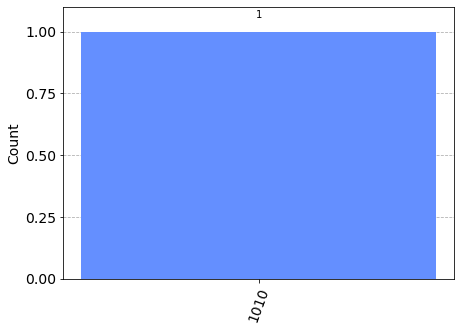

In [22]:
plot_histogram(result.get_counts(circuits[0]))

In [23]:
ePatterns = [
    re.compile('00..$'), # search for the '00..' result (Eve obtained the results -1 and -1 for Alice's and Bob's qubits)
    re.compile('01..$'), # search for the '01..' result (Eve obtained the results 1 and -1 for Alice's and Bob's qubits)
    re.compile('10..$'),
    re.compile('11..$')  
]

In [24]:
aliceResults = [] # Alice's results (string a)
bobResults = [] # Bob's results (string a')

# list of Eve's measurement results
# the elements in the 1-st column are the results obtaned from the measurements of Alice's qubits
# the elements in the 2-nd column are the results obtaned from the measurements of Bob's qubits
eveResults = [] 

# recording the measurement results
for j in range(numberOfSinglets):
    
    res = list(result.get_counts(circuits[j]).keys())[0] # extract a key from the dict and transform it to str
    
    # Alice and Bob
    if abPatterns[0].search(res): # check if the key is '..00' (if the measurement results are -1,-1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(-1) # Bob got the result -1
    if abPatterns[1].search(res):
        aliceResults.append(1)
        bobResults.append(-1)
    if abPatterns[2].search(res): # check if the key is '..10' (if the measurement results are -1,1)
        aliceResults.append(-1) # Alice got the result -1 
        bobResults.append(1) # Bob got the result 1
    if abPatterns[3].search(res): 
        aliceResults.append(1)
        bobResults.append(1)

    # Eve
    if ePatterns[0].search(res): # check if the key is '00..'
        eveResults.append([-1, -1]) # results of the measurement of Alice's and Bob's qubits are -1,-1
    if ePatterns[1].search(res):
        eveResults.append([1, -1])
    if ePatterns[2].search(res):
        eveResults.append([-1, 1])
    if ePatterns[3].search(res):
        eveResults.append([1, 1])

In [25]:
aliceKey = [] # Alice's key string a
bobKey = [] # Bob's key string a'
eveKeys = [] # Eve's keys; the 1-st column is the key of Alice, and the 2-nd is the key of Bob

# comparing the strings with measurement choices (b and b')
for j in range(numberOfSinglets):
    # if Alice and Bob measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
    if (aliceMeasurementChoices[j] == 2 and bobMeasurementChoices[j] == 1) or (aliceMeasurementChoices[j] == 3 and bobMeasurementChoices[j] == 2):  
        aliceKey.append(aliceResults[j]) # record the i-th result obtained by Alice as the bit of the secret key k
        bobKey.append(-bobResults[j]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'
        eveKeys.append([eveResults[j][0], -eveResults[j][1]]) # record the i-th bits of the keys of Eve 

keyLength = len(aliceKey) # length of the secret skey

In [26]:
abKeyMismatches = 0 # number of mismatching bits in the keys of Alice and Bob
eaKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Alice
ebKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Bob

for j in range(keyLength):
    if aliceKey[j] != bobKey[j]: 
        abKeyMismatches += 1
    if eveKeys[j][0] != aliceKey[j]:
        eaKeyMismatches += 1
    if eveKeys[j][1] != bobKey[j]:
        ebKeyMismatches += 1

In [27]:
eaKnowledge = (keyLength - eaKeyMismatches)/keyLength # Eve's knowledge of Bob's key
ebKnowledge = (keyLength - ebKeyMismatches)/keyLength # Eve's knowledge of Alice's key

In [28]:
corr = chsh_corr(result)

In [29]:
# CHSH inequality test
print('CHSH correlation value: ' + str(round(corr, 3)) + '\n')

# Keys
print('Length of the key: ' + str(keyLength))
print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

CHSH correlation value: -1.208

Length of the key: 122
Number of mismatching bits: 17

Eve's knowledge of Alice's key: 90.98 %
Eve's knowledge of Bob's key: 95.08 %
